# Motivation

In [1]:
import spacy
from spacy import displacy
nlp = spacy.load('en')

Finding the tag of a word may require interation between different parts of a the sentence. That implies that nay model that just consider the words immediately next to the target word have an implicit limitation.

In [2]:
doc = nlp(u"Deep Learning has been proven useful to encode the the realtions of words in sentence. Let's give it a go!")
displacy.render(doc, style='dep', jupyter=True)

# Code

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *        # Quick access to most common functionality
from fastai.text import * 
import ast

In [5]:
torch.cuda.set_device(0)

In [6]:
path = Path('/data/miguel/ML1_final_project/databunch/')
bs=16

### Data preprocessing

In [7]:
# Labels in a standard string format separated by ,
train_df = pd.read_csv(str(path/'train.csv'), names=['label','text'])
train_df.label = train_df.label.map(lambda x: x[1:-1])
train_df.head(3)

,label,text
0,"16, 16, 9, 16, 15, 16, 16, 31, 16, 9, 7, 16, 3...",Joint Chiefs of Staff Chairman Mike Mullen sai...
1,"7, 18, 16, 31, 7, 15, 1, 36, 31, 7, 15, 40, 34...",The activists Saturday presented the postcard ...
2,"21, 34, 10, 18, 14, 30, 33, 9, 15, 9, 7, 15, 2",They say other people will be questioned in co...


In [8]:
# Setting the validation data in the same format as the training data.
valid_df = pd.read_csv(str(path/'valid.csv'), names=['label','text'])
valid_df.label = valid_df.label.map(lambda x: x[1:-1])
valid_df.text = [' '.join(ast.literal_eval(row)) for row in valid_df.text]
valid_df.head(3)

,label,text
0,"18, 34, 7, 16, 16, 5, 10, 16, 9, 15, 9, 7, 10,...",Palestinians claim the West Bank and east Jeru...
1,"7, 10, 15, 31, 7, 15, 2",The second test was a draw .
2,"16, 35, 33, 23, 6, 18, 9, 15, 5, 15, 9, 7, 15,...",Somalia has experienced nearly two decades of ...


In [9]:
# Obtaining the classes
with open('/data/miguel/ML1_final_project/deliverables/classes.txt','r') as f:
    cl = f.readlines()
cls = [tag[:-1] for tag in cl]
print(cls)

[',', '.', ':', ';', 'CC', 'CD', 'DT', 'EX', 'IN', 'JJ', 'JJR', 'JJS', 'LRB', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'RRB', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


# Tokenization

*What tokenization is the dataest using?*
Here we check that splitting it word by word is indeed the way to proceed.

In [10]:
for row in range(len(train_df)):
    assert len(train_df.label[row].split(', '))==len(train_df.text[row].split()), f'First problem in line {row}'

# Pre-Rules, special cases and post-rules.

Here balance the pre-rules, special cases and pos-rules with two main goals in mind:

* Make the tokenized sequences as similar as possible to the pre-trained model.
* Make the sequences structure suitable for our problem.

Currently the most suitable option seems to be leaving the `default_pre_rules` and `default_spec_cases`. Regarding the post-rules we will modify them to make the words be lower case and don't add an extra token before those words starting with capital a capital letter.

In [11]:
post_rules = []

# The Language Model

We won't load the pretrained version of the language model in the `fast-ai` library because this will reduce the embeddings we have access to. Instead we initialize the weights at random and train for arround 20 epochs a Lenguage Model in an `IMDB` corpus of movie comments.

In [12]:
lm_path = untar_data(URLs.IMDB)

In [13]:
data_lm = (TextList.from_folder(lm_path, tokenizer = Tokenizer(SpacyTokenizer2, post_rules=post_rules))
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))

data_lm.save('tmp_lm')

In [14]:
learn = language_model_learner(data_lm, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


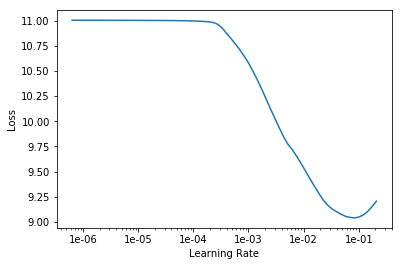

In [15]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-03, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy


In [ ]:
learn.fit_one_cycle(10, 1e-03, moms=(0.8,0.7))

Saving both the full model (in case we may use it in a future) and the encoder (Embeddings + LSTM's) to do transfer learning with this part.

In [18]:
learn.save('fit_LM')
learn.save_encoder('fine_tuned_enc')
! cp -r /data/miguel/.fastai/data/imdb/models/fit_LM.pth /data/miguel/ML1_final_project/databunch/models/
! cp -r /data/miguel/.fastai/data/imdb/models/fine_tuned_enc.pth /data/miguel/ML1_final_project/databunch/models/

/data/miguel/.fastai/data/imdb/models/fit_LM.pth


# The Labeler

In [19]:
path = Path('/data/miguel/ML1_final_project/databunch')

In [59]:
data_labeler = (TextLabelerDataBunch
                .from_df(path, train_df=train_df, valid_df=valid_df
                         , tokenizer = Tokenizer(SpacyTokenizer2, post_rules=post_rules)
                         , vocab=data_lm.vocab)
               )

In [73]:
learn = text_labeler_learner(data_labeler, drop_mult=.5, metrics=[labeler_accuracy])
learn.load_encoder('fine_tuned_enc')
learn.freeze()

### Double checking the data feeding the model

In [61]:
x_tr,y_tr = data_labeler.train_ds[0]
print(x_tr.text,y_tr)
# x_tr_dl,y_tr_dl = next(iter(data_labeler.train_dl))
# x_tr_dl,y_tr_dl

xxbos xxunk 1 joint chiefs of staff chairman mike mullen said sunday that the u.s. has a plan to strike iran . [16, 16, 9, 16, 15, 16, 16, 31, 16, 9, 7, 16, 35, 7, 15, 28, 30, 16, 2]


In [62]:
x_val,y_val = data_labeler.valid_ds[0]
print(x_val.text,y_val)
# x_val_dl,y_val_dl = next(iter(data_labeler.valid_dl))
# x_val_dl,y_val_dl

xxbos xxunk 1 palestinians claim the west bank and east jerusalem as part of a future palestinian state . [18, 34, 7, 16, 16, 5, 10, 16, 9, 15, 9, 7, 10, 10, 15, 2]


### Fine-Tunning time

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


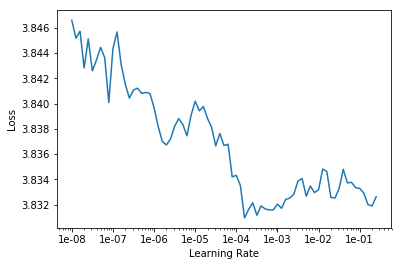

In [75]:
learn.lr_find(start_lr=1e-9)
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-06, moms=(0.8,0.7))

epoch,train_loss,valid_loss,labeler_accuracy


In [31]:
learn.save('first');
learn.load('first');

/data/miguel/ML1_final_project/databunch/models/first.pth


In [32]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-06/(2.6**4),1e-06), moms=(0.8,0.7))

epoch,train_loss,valid_loss,labeler_accuracy
1,30.291292,60.288734,0.043998


In [35]:
learn.save('second');
learn.load('second');

In [36]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-7/(2.6**4),5e-7), moms=(0.8,0.7))

epoch,train_loss,valid_loss,labeler_accuracy
1,30.237640,60.238869,0.022157


In [37]:
learn.save('third');
learn.load('third');

/data/miguel/ML1_final_project/databunch/models/third.pth


In [38]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-7/(2.6**4),1e-7), moms=(0.8,0.7))

epoch,train_loss,valid_loss,labeler_accuracy
1,30.324617,60.497372,0.027171


*Note: The project is still under review to try possible changes to make it train properly.*

# Appendinx: Modifications in the FastAI library (local copy) 

To develop this algorithm multiple modifications in various modules of the verion `1.0.31` of fastai were necessary. Those modifications include but are not limited to the following ones:

*Note: We follow the library's code standard for this section.* 🤷‍♂️ 

### `text/data`

In [ ]:
# Native class for text labeling. This is in charge of constructing the dataset and the dataloader.
class TextLabelerDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN labeler."

    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs=16, pad_idx=1, pad_first=True,
               **kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for labeling."
        datasets = [train_ds,valid_ds]
        if test_ds is not None: datasets.append(test_ds)
        collate_fn = partial(pad_collate_labeler, pad_idx=pad_idx, pad_first=pad_first)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs // 2)
        train_dl = DataLoader(datasets[0], batch_size=bs // 2, sampler=train_sampler, collate_fn=collate_fn,  **kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            sampler = SortSampler(ds.x, key=lambda t: len(ds[t][0].data))
            dataloaders.append(DataLoader(ds, batch_size=bs, sampler=sampler,  **kwargs))
        return cls(*dataloaders, path=path, collate_fn=collate_fn)

In [ ]:
def pad_collate_labeler(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding for text labeling."

    max_len = max([len(s[0].data) for s in samples])
    res = torch.zeros(max_len, len(samples)).long() + pad_idx
    lres = torch.zeros(max_len, len(samples)).long() - pad_idx
    for i,s in enumerate(samples):
        if pad_first:
            res[-len(s[0].data):,i] = LongTensor(s[0].data)
            lres[-len(s[1]):,i] = LongTensor(s[1])
        else:
            res[:len(s[0].data):,i] = LongTensor(s[0].data);
            lres[:len(s[1]):,i] = LongTensor(s[1])
    return res, lres

### `text/models`

In [ ]:
class LinearLabeler(nn.Module):
    "Create the last layers of a linear labeler."

    def __init__(self, layers: Collection[int], drops: Collection[float]):
        super().__init__()
        mod_layers = []
        activs = [nn.ReLU(inplace=True)] * (len(layers) - 2) + [None] #nn.Softmax(dim=-1)
        for n_in, n_out, p, actn in zip(layers[:-1], layers[1:], drops, activs):
            mod_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn)  # bn_drop_lin_2d(n_in, n_out, p=p, actn=actn)
        self.layers = nn.Sequential(*mod_layers)

    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor, Tensor]:
        raw_outputs, outputs = input

        output = outputs[-1]
        sl, bs, _ = output.size()
        X = []
        for i in range(output.size()[0]):
            x = output[i, :, :]
            out = self.layers(x)
            X.append(out.unsqueeze(0))
        X = torch.cat(X, 0)
        return X, raw_outputs, outputs

In [ ]:
def get_rnn_labeler(bptt:int, max_seq:int, n_class:int, vocab_sz:int, emb_sz:int, n_hid:int, n_layers:int,
                       pad_token:int, layers:Collection[int], drops:Collection[float], bidir:bool=False, qrnn:bool=False,
                       hidden_p:float=0.2, input_p:float=0.6, embed_p:float=0.1, weight_p:float=0.5)->nn.Module:
    "Create a RNN labeler model."
    rnn_enc = MultiBatchRNNCore(bptt, max_seq, vocab_sz, emb_sz, n_hid, n_layers, pad_token=pad_token, bidir=bidir,
                      qrnn=qrnn, hidden_p=hidden_p, input_p=input_p, embed_p=embed_p, weight_p=weight_p)
    return SequentialRNN(rnn_enc, LinearLabeler(layers, drops))

## `text/transform`

In [ ]:
class SpacyTokenizer2(BaseTokenizer):
    "Tokenizer using a modification of spacy.blank() to preserve the 'amount of words' in a sequence"
    def __init__(self, lang:str):
        self.tok = spacy.blank(lang)

    def tokenizer(self, t:str) -> List[str]:
        tokenized = []
        for tok in t.split(' '):
            if len(self.tok.tokenizer(tok)) > 1:
                tokenized.append(self.tok.tokenizer(tok)[0].text.lower())
            else:
                tokenized.append(self.tok.tokenizer(tok).text.lower())
        return tokenized

## `text/learner`

In [ ]:
class labeler_loss(torch.nn.Module):
    'Word-wise cross entropy ignoring padding positions'
    def __init__(self):
        super(labeler_loss, self).__init__()

    def forward(self, pred, y):
        tot_sum = 0
        tot_words = 0
        for i in range(pred.shape[1]):
            idx = int([(y[:,i]>0).nonzero()][0][0].data.cpu().numpy()[0])
            seq_words = len(range(idx,y.shape[0]))
            tot_words += seq_words
            tot_sum = tot_sum + seq_words*F.cross_entropy(pred[idx:, i, :], y[idx:, i])
        return tot_sum/tot_words

## `../metrics`

In [20]:
def labeler_accuracy(input:Tensor, targs:LongTensor)->Rank0Tensor:
    "Accuracy for labeler comparing non-padded positions"
    inputs = torch.empty(0, input.shape[2]).cuda()
    flattened_targs = torch.empty(0).cuda().long()
    for i in range(input.shape[1]):
        idx = int([(targs[:,i]>0).nonzero()][0][0].data.cpu().numpy()[0])
        flattened_targs = torch.cat((flattened_targs,targs[idx:,i]),0)
        inputs = torch.cat((inputs, input[idx:,i,:]),0)
    inputs = inputs.argmax(dim=-1)
    return (inputs==flattened_targs).float().mean()

*Note: To see the complete integration go to the `../fastai` which contains a copy of the library*